In [1]:
from vmad import Builder, autooperator, operator
import numpy as np
from nbodykit.cosmology import Planck15
from vmad.core.stdlib.operators import mul, div, add, sub
from vmad.core.stdlib.operators import pow as power
from vmad.lib.unary import log
#need sinc, exp, sqrt
from vmad.lib.unary import sinc, exp



In [139]:
def normalize(r,cosmo,transfer='EH', kmin=1e-5, kmax=1e1):
    r"""
    The mass fluctuation within a sphere of radius ``r``, in
    units of :math:`h^{-1} Mpc` at ``redshift``.
    This returns :math:`\sigma`, where
    .. math::
        \sigma^2 = \int_0^\infty \frac{k^3 P(k,z)}{2\pi^2} W^2_T(kr) \frac{dk}{k},
    where :math:`W_T(x) = 3/x^3 (\mathrm{sin}x - x\mathrm{cos}x)` is
    a top-hat filter in Fourier space.
    The value of this function with ``r=8`` returns
    :attr:`sigma8`, within numerical precision.
    Parameters
    ----------
    r : float, array_like
        the scale to compute the mass fluctation over, in units of
        :math:`h^{-1} Mpc`
    kmin : float, optional
        the lower bound for the integral, in units of :math:`\mathrm{Mpc/h}`
    kmax : float, optional
        the upper bound for the integral, in units of :math:`\mathrm{Mpc/h}`
    """
    import mcfit
    from scipy.interpolate import InterpolatedUnivariateSpline as spline
    
    k_norm = np.logspace(np.log10(kmin), np.log10(kmax), 1024)
    
    if transfer=='EH':
        temp_p= get_Pk_EH.build(cosmo=cosmo, z=0, k=k_norm)
    
    elif transfer=='NWEH':
        temp_p= get_Pk_NWEH.build(cosmo=cosmo, z=0, k=k_norm)
    
    else:
        raise ValueError('transfer must be EH or NWEH')



    Pk = temp_p.compute(init = dict(Omega0_m=cosmo.Omega0_m),vout=['Pk'], return_tape=False)
    R, sigmasq = mcfit.TophatVar(k_norm, lowring=True)(Pk, extrap=True)
    
#     return (cosmo.sigma8/spline(R, sigmasq)(r)**.5)
    return spline(R, sigmasq)(r)**.5

In [140]:
normalize(8, cosmo, transfer='NWEH'), normalize(8, cosmo,transfer='EH')

(0.0004515597422307785, 0.00046762306840068216)

In [135]:
test = cosmology.LinearPower(cosmo, 1, transfer='NoWiggleEisensteinHu')

In [138]:
test.sigma_r(8)

0.7052332875166213

# Eisenstein Hu Autooperators

In [66]:
cosmo.sigma8

0.8158001637472496

In [67]:
cosmo = Planck15
cosmo = cosmo.match(sigma8=.8158)
cosmo = cosmo.clone(P_k_max=30)


\begin{equation}
\delta_H = 1.94\times 10^{-5}\Omega_{m,0}^{-.785-.05ln(\Omega_{m,0})}e^{\tilde{n}+1.97\tilde{n}^2}
\end{equation}

\begin{equation}
\dfrac{\partial\delta_H}{\partial \Omega_{m,0}} = 1.94\times 10^{-5}\left(-.785 + .05\ln(\Omega_{m,0})\right)\Omega_{m,0}^{-1.785 + .05\ln(\Omega_{m,0})}e^{\tilde{n}+1.97\tilde{n}^2}\dfrac{.05}{\Omega_{m,0}}
\end{equation}

In [68]:
@autooperator('omega0_m->delta_h')
def amplitude(omega0_m, n):
    factor_1 = mul(1.94e-5, power(omega0_m, sub(-.785, mul(.05, log(omega0_m)))))
    factor_2 = np.e**((n - 1) + 1.97 * (n - 1)**2)
    
    return dict(delta_h = mul(factor_1, factor_2))

\begin{equation}
    D_1(z) = (1+z)^{-1}\dfrac{5\Omega(z)}{2}\left[\Omega(z)^{4/7}-\Omega_\Lambda(z) +(1+\Omega(z)/2)(1+\Omega_\Lambda(z)/70)\right]^{-1}
\end{equation}

\begin{equation}
\begin{split}
\dfrac{\partial D_1(z)}{\partial \Omega} &= \dfrac{(1+z)^{-1}\dfrac{5}{2}}{\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70)}\left[1 - \dfrac{\Omega(z)\left( 4/7 \Omega (z)^{-3/7}+1/2+\Omega_\Lambda(z)/140\right)}{[\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70)}\right]\\
\dfrac{\partial D_1(z)}{\partial \Omega_\Lambda} &= -\dfrac{5\Omega (z)(-1+1/70+\Omega(z)/140)}{2(1+z)(\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70))^2}
\end{split}
\end{equation}


In [69]:
@autooperator('omega_z, omega_lambda->growth')
def grow(omega_z, omega_lambda, z):
    pre_fac = mul((1+z)**-1, div(mul(5, omega_z), 2))
    inside = power(
        add(sub(power(omega_z, 4/7), omega_lambda), 
            mul(add(1, div(omega_z,2)), 
                add(1, div(omega_lambda,70)))), 
        -1)
    return dict(growth=mul(pre_fac, inside))

\begin{equation}
\Omega(z) = \dfrac{\Omega_0 (1+z)^3}{\Omega_\Lambda+\Omega_0(1+z)^3}
\end{equation}

\begin{equation}
\dfrac{\partial \Omega(z)}{\partial \Omega_{0}} = \dfrac{(1+z)^3}{\Omega_\Lambda+\Omega_0(1+z)^3}\left[1 - \dfrac{\Omega_0 (1+z)^3}{\left(\Omega_\Lambda+\Omega_0(1+z)^3\right)}\right]
\end{equation}

In [70]:
@autooperator('omega0_m->omega_z')
def get_omega_z(omega0_m, z):
    omega0_l = sub(1, omega0_m)
    num      = mul(omega0_m, (1+z)**3)
    denom    = add(omega0_l, mul(omega0_m, (1+z)**3))
    return dict(omega_z = div(num, denom))

\begin{equation}
\Omega_\Lambda(z) = \dfrac{1-\Omega_0}{1-\Omega_0 + \Omega_0(1+z)^3}
\end{equation}

\begin{equation}
\dfrac{\partial \Omega_\Lambda(z)}{\partial \Omega_0} = \dfrac{-1}{1-\Omega_0 +\Omega_0(1+z)^3} - \dfrac{1-\Omega_0(-1+(1+z)^3)}{\left(1-\Omega_0+\Omega_0(1+z)^3\right)^2}
\end{equation}

In [71]:
@autooperator('omega0_m->omega_lambda')
def get_omega_lambda(omega0_m, z):
    omega0_l = sub(1, omega0_m)
    denom = add(omega0_l, mul(omega0_m, (1+z)**3))
    return dict(omega_lambda = div(omega0_l, denom))

In [72]:
@autooperator('a,b,q->c')
def f(a,b,q):
    return dict(c =div( a , add(a ,mul( b,power(q,2)))))

In [73]:
cosmo.T0_cmb

2.7255

In [95]:
@autooperator('Omega0_m->Pk, g')
def get_Pk_NWEH(Omega0_m, cosmo, z, k):

    Obh2 =cosmo.Omega0_b * cosmo.h**2
    Omh2 = mul(Omega0_m, power(cosmo.h, 2))
    f_baryon = div(cosmo.Omega0_b, Omega0_m)

    theta_cmb = cosmo.Tcmb0 / 2.7

    k_eq =mul(0.0746, mul(Omh2,power(theta_cmb,-2))) # units of 1/Mpc

    sound_horizon =div(mul(mul( cosmo.h, 44.5), log(div(9.83,Omh2))) ,power(add(1, mul(10, power(Obh2, 0.75))), .5)) # in Mpc/h
    alpha_gamma = sub(1, add(mul(mul(0.328, log(mul(431, Omh2))), f_baryon), mul(mul(0.38, log(mul(22.3, Omh2))), power(f_baryon ,2))))
    #zeromode=1 conserves mean
    #k = k.normp(p=2,zeromode=1)
    
    k = np.asarray(k) * cosmo.h  # in 1/Mpc now
    
    ks = div(mul(k, sound_horizon), cosmo.h)
    q = div(k, mul(13.41, k_eq))

    gamma_eff = mul(Omh2, add(alpha_gamma, div(sub(1, alpha_gamma), add(1, power(mul(0.43,ks), 4)))))

    q_eff = mul(q, div(Omh2, gamma_eff))

    L0 = log(add(mul(2,np.e), mul(1.8, q_eff)))
    C0 = add(14.2, div(731.0, add(1, mul(62.5, q_eff))))

    T = div(L0, add(L0, mul(C0,power(q_eff,2))))

    ### ADD GROWTH###
    omega_zs = get_omega_z(Omega0_m, z)
    omega_lambdas = get_omega_lambda(Omega0_m, z)
    growth_z = grow(omega_zs, omega_lambdas, z)
    omega_zs = get_omega_z(Omega0_m, 0)
    omega_lambdas = get_omega_lambda(Omega0_m, 0)
    growth_0 = grow(omega_zs, omega_lambdas, 0)

    factor = (k/cosmo.h)**cosmo.n_s

    Pk = mul(power(mul(T, div(growth_z, growth_0,)),2),factor)
    
    return dict(Pk=Pk, g=growth_z**2/growth_0**2)
    

@autooperator('Omega0_m->Pk')
def get_Pk_EH(Omega0_m, cosmo, z, k):

    Obh2 = cosmo.Omega0_b * cosmo.h ** 2
    Omh2 = mul(Omega0_m, power(cosmo.h, 2))
    f_baryon = div(cosmo.Omega0_b, Omega0_m)
    theta_cmb = cosmo.Tcmb0 / 2.7

    # z and wavenumber of equality
    z_eq = mul(mul(2.5e4, Omh2),theta_cmb ** (-4)) # this is 1 + z
    k_eq = mul(mul(0.0746, Omh2),theta_cmb ** (-2)) # units of 1/Mpc

    # sound horizon and k_silk
    z_drag_b1 = mul(mul(0.313, power(Omh2, -0.419)), add(1, mul(0.607,power(Omh2, 0.674))))
    z_drag_b2 = mul(0.238, power(Omh2,0.223))
    z_drag    = mul(div(mul(1291, power(Omh2, 0.251)), add(1., mul(0.659, power(Omh2, 0.828)))), add(1., mul(z_drag_b1, power(Obh2, z_drag_b2))))



    r_drag = div(31.5 * Obh2 * theta_cmb ** -4 * 1000., add(1,z_drag))
    r_eq   = div(31.5 * Obh2 * theta_cmb ** -4 * 1000., z_eq)

    sound_horizon = mul(mul(div(2., mul(3.,k_eq)),power(div(6., r_eq), .5)), \
                    log(div(add(power(add(1,r_drag), .5), power(add(r_drag,r_eq), .5)), add(1, power(r_eq, .5)))))

    k_silk = mul(mul(1.6 * Obh2 ** 0.52, power(Omh2,0.73)),add(1, power(mul(10.4,Omh2), -0.95)))

    # alpha_c
    alpha_c_a1 = mul(power(mul(46.9,Omh2),0.670 ), add(1, power(mul(32.1,Omh2), -0.532)))
    alpha_c_a2 = mul(power(mul(12.0,Omh2), 0.424), add(1, power(mul(45.0,Omh2), -0.582)))
    alpha_c = mul(power(alpha_c_a1, -f_baryon), power(alpha_c_a2 , power(-f_baryon,3)))

    # beta_c
    beta_c_b1 = div(0.944, add(1, power(mul(458,Omh2), -0.708)))
    beta_c_b2 = mul(0.395, power(Omh2, -0.0266))
    beta_c = div(1., add(1 , sub(mul(beta_c_b1, power(sub(1,f_baryon), beta_c_b2)), 1)))

    y = div(z_eq, add(1, z_drag))
    alpha_b_G = mul(y, \
                    add(mul(-6.,power(add(1,y), .5)),
                        mul(add(2.,mul(3.,y)),
                            log(div(add(power(add(1,y), .5),1),sub(power(add(1,y), .5),1))))))
    alpha_b = mul(mul(mul(2.07,  k_eq), sound_horizon), mul(power(add(1,r_drag),-0.75), alpha_b_G))

    beta_node = mul(8.41, power(Omh2, 0.435))
    beta_b    = add(add(0.5, f_baryon), mul(sub(3., mul(2.,f_baryon)),power( add(power(mul(17.2,Omh2), 2), 1 ), .5)))

    k = k * cosmo.h # now in 1/Mpc

    q = div(k, mul(13.41,k_eq))
    ks = mul(k,sound_horizon)

    T_c_ln_beta   = log(add(np.e, mul(mul(1.8,beta_c),q)))
    T_c_ln_nobeta = log(add(np.e, mul(1.8,q)));

    T_c_C_alpha   = add(div(14.2, alpha_c), div(386., add(1, mul(69.9,power( q, 1.08)))))


    T_c_C_noalpha = add(14.2,  div(386., add(1, mul(69.9, power(q, 1.08)))))


    T_c_f = div(1., add(1.,power(div(ks,5.4), 4)))


    T_c = add(mul(T_c_f, f(T_c_ln_beta, T_c_C_noalpha, q)), mul(sub(1,T_c_f), f(T_c_ln_beta, T_c_C_alpha,q)))


    s_tilde = mul(sound_horizon, power(add(1, power(div(beta_node,ks),3)), (-1./3.)))


    ks_tilde = mul(k,s_tilde)


    T_b_T0 = f(T_c_ln_nobeta, T_c_C_noalpha, q)


    T_b_1 = div(T_b_T0, add(1, power(div(ks,5.2),2 )))


    T_b_2 = mul(div(alpha_b, add(1, power(div(beta_b,ks),3 ))), exp(-power(div(k,k_silk), 1.4)))


    T_b = mul(sinc(div(ks_tilde,np.pi)), add(T_b_1, T_b_2))

    T = add(mul(f_baryon,T_b), mul(sub(1,f_baryon),T_c));
    
    ### ADD GROWTH###
    omega_zs = get_omega_z(Omega0_m, z)
    omega_lambdas = get_omega_lambda(Omega0_m, z)
    growth_z = grow(omega_zs, omega_lambdas, z)
    omega_zs = get_omega_z(Omega0_m, 0)
    omega_lambdas = get_omega_lambda(Omega0_m, 0)
    growth_0 = grow(omega_zs, omega_lambdas, 0)

    factor = (k/cosmo.h)**cosmo.n_s

    Pk = mul(mul(power(T, 2), div(power(growth_z, 2),power(growth_0,2))),factor)


    return dict(Pk=Pk)

In [96]:
k = np.linspace(.005, 1.5, 1e5)
z = 10

Pk_NWEH, g= get_Pk_NWEH.build(cosmo=cosmo, z=z, k=k).compute(init = dict(Omega0_m=cosmo.Omega0_m),\
                                                                         vout=['Pk','g'], return_tape=False)
Pk_EH= get_Pk_EH.build(cosmo=cosmo, z=z, k=k).compute(init = dict(Omega0_m=cosmo.Omega0_m),\
                                                                         vout='Pk', return_tape=False)
Pk_NWEH *= normalize(8, cosmo,transfer='NWEH')
Pk_EH   *= normalize(8, cosmo,transfer='EH')

In [97]:
np.sqrt(g), cosmo.scale_independent_growth_factor(10)

(0.11601301338387322, array(0.11674667))

(3263902.206614416, 3043516.8879525037)

In [32]:
from nbodykit import cosmology

In [47]:
cosmology.LinearPower(cosmo, z, transfer='NoWiggleEisensteinHu')._norm

3041410.730072215

In [154]:
NWEH_cos = cosmology.LinearPower(cosmo, z, transfer='NoWiggleEisensteinHu').__call__(k)
EH_cos = cosmology.LinearPower(cosmo, z, transfer='EisensteinHu').__call__(k)
CLASS_cos = cosmology.LinearPower(cosmo, z, transfer='CLASS').__call__(k)

In [155]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


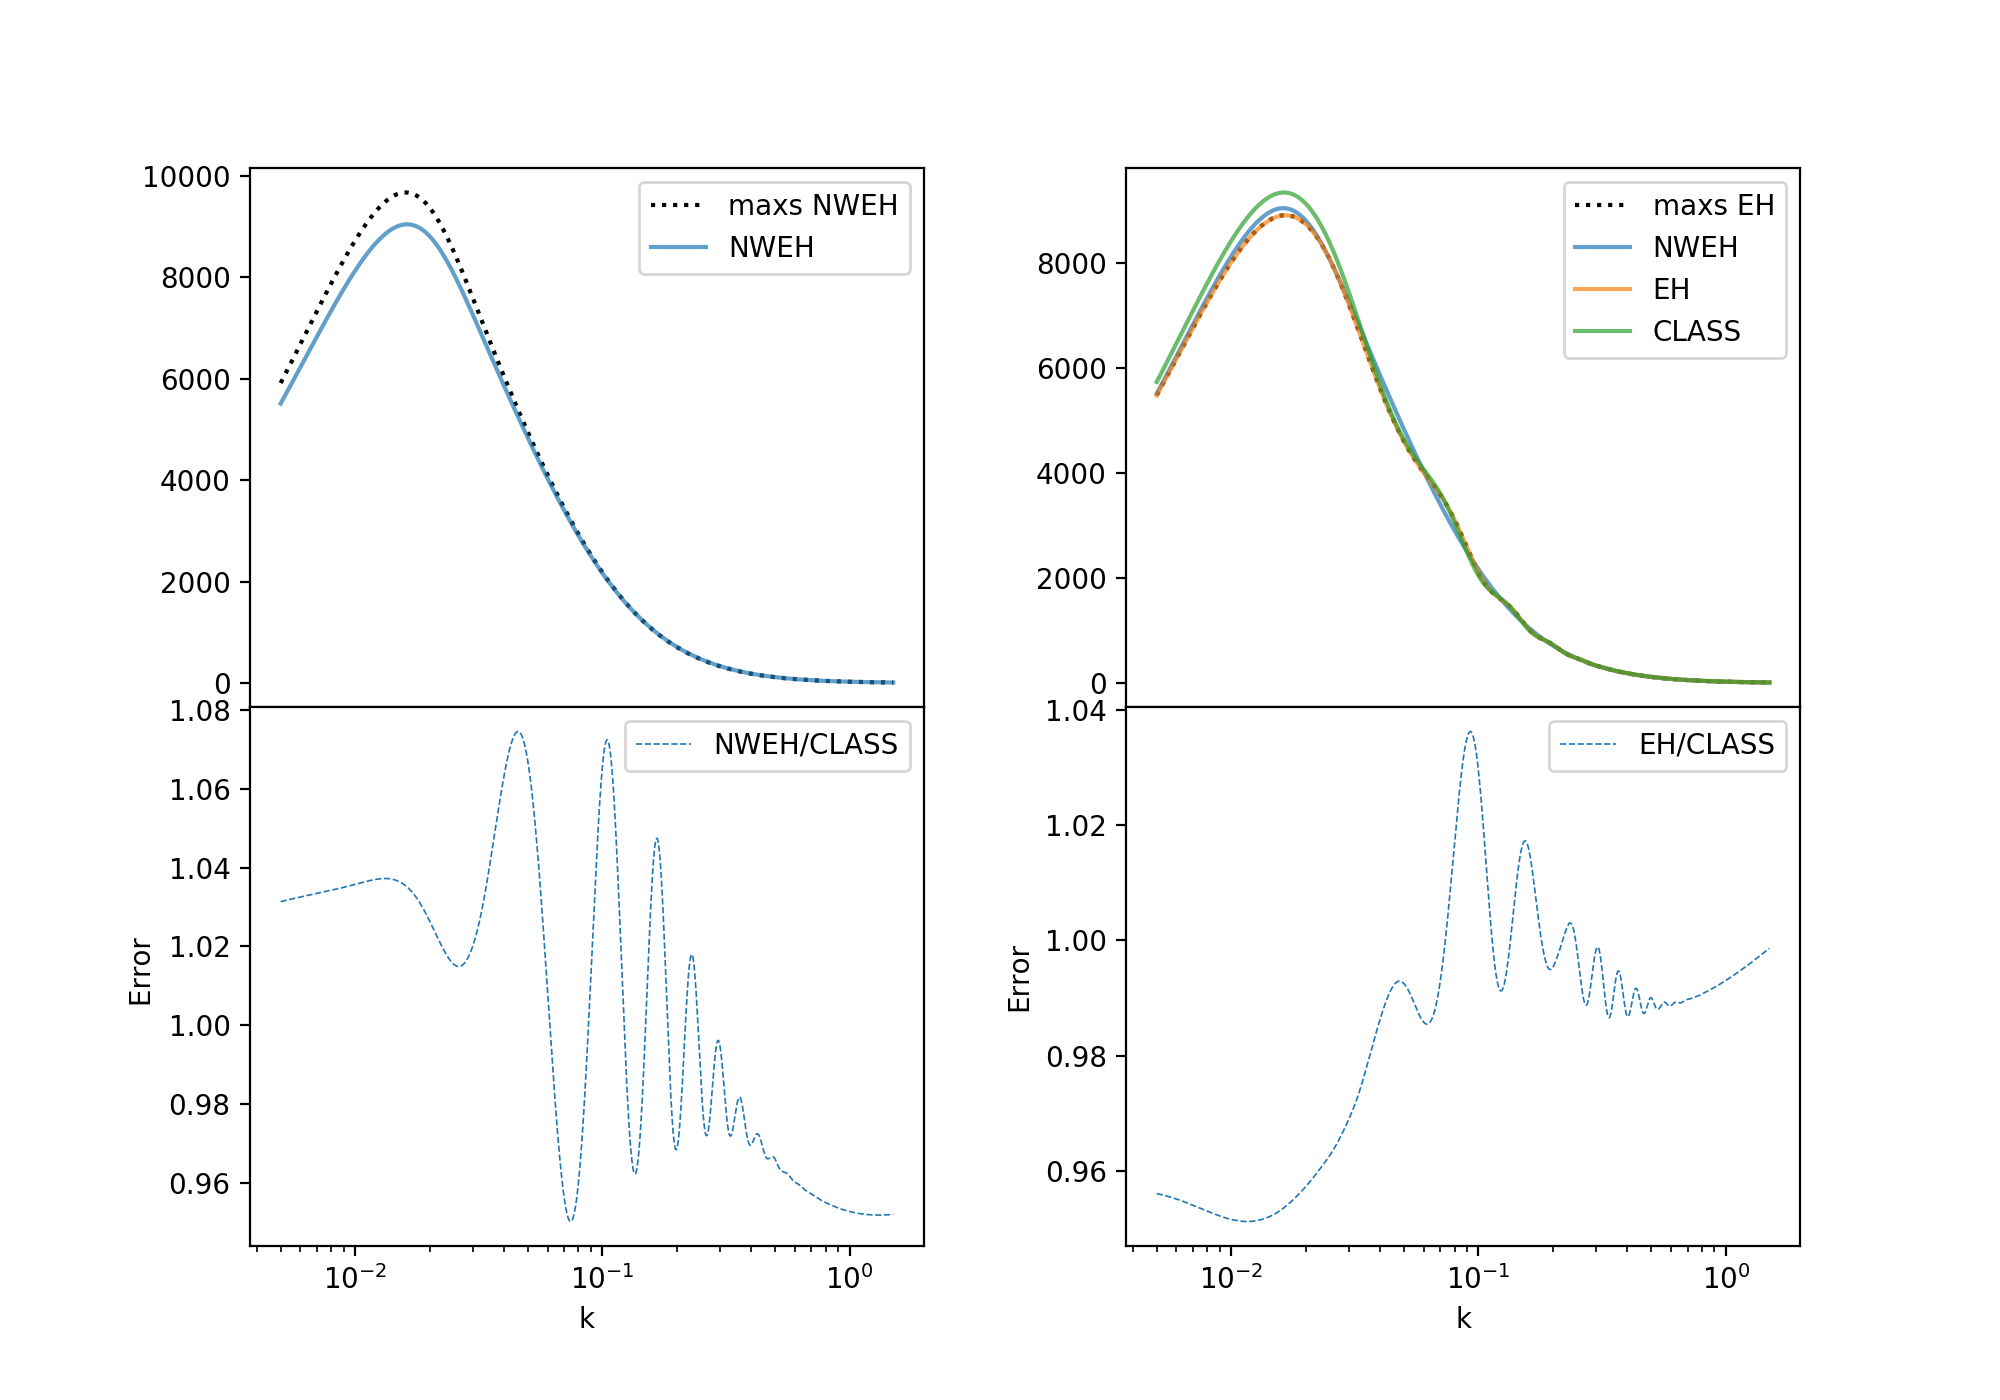

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [156]:
#PLOT
fig, axs = plt.subplots(nrows=2,ncols=2, sharex=True, gridspec_kw={'hspace': 0, 'wspace':.3}, figsize=(10,7))
axs[0,0].semilogx(k, Pk_NWEH, ':k', label='maxs NWEH')
axs[0,0].semilogx(k, NWEH_cos, label='NWEH', alpha=.7)
# axs[0,0].semilogx(k, EH_cos, label='EH', alpha=.7)
# axs[0,0].semilogx(k, CLASS_cos, label='CLASS', alpha=.7)
axs[0,0].legend()

axs[1,0].set_xlabel('k')
axs[1,0].set_ylabel('Power Spectrum')
axs[1,0].legend()
axs[1,0].semilogx(k, Pk_NWEH/CLASS_cos, '--', label='NWEH/CLASS', lw=.6)
axs[1,0].set_ylabel(' Error')
axs[1,0].legend()

axs[0,1].semilogx(k, Pk_EH, ':k', label='maxs EH')
axs[0,1].semilogx(k, NWEH_cos, label='NWEH', alpha=.7)
axs[0,1].semilogx(k, EH_cos, label='EH', alpha=.7)
axs[0,1].semilogx(k, CLASS_cos, label='CLASS', alpha=.7)
axs[0,1].legend()



axs[1,1].set_xlabel('k')
axs[1,1].set_ylabel('Power Spectrum')
axs[1,1].legend()
axs[1,1].semilogx(k, Pk_EH/CLASS_cos, '--', label='EH/CLASS', lw=.6)
axs[1,1].set_ylabel('Error')
axs[1,1].legend()

plt.tight_layout()

In [63]:
vjp = tape_NWEH.get_vjp()
_Omega0_m_NWEH = vjp.compute(init=dict(_Pk=1), vout='_Omega0_m')

vjp = tape_EH.get_vjp()
_Omega0_m_EH = vjp.compute(init=dict(_Pk=1), vout='_Omega0_m')

<IPython.core.display.Javascript object>


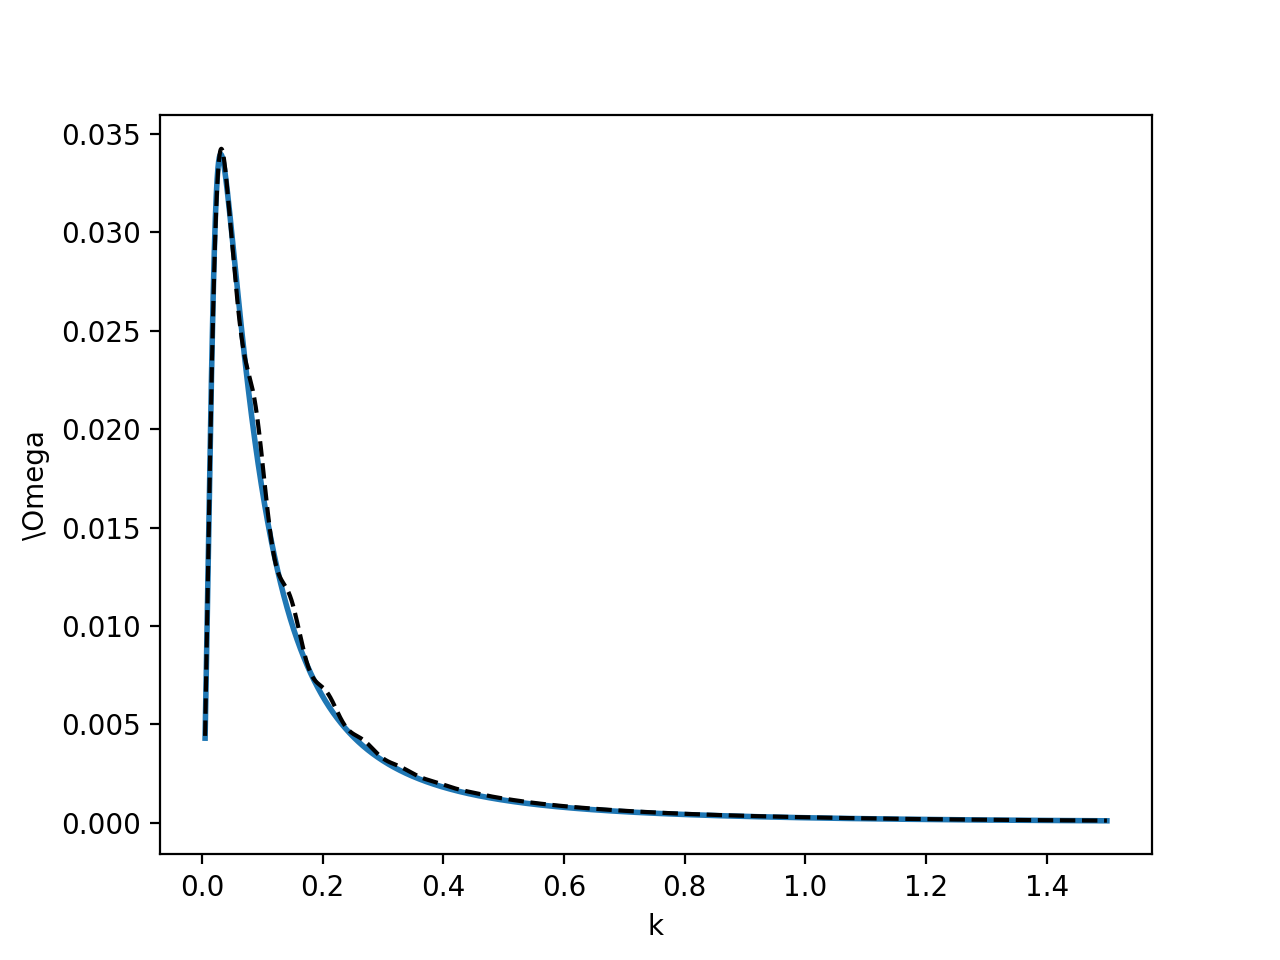

Text(0, 0.5, '\\Omega')

In [67]:
plt.figure()
plt.plot(k, _Omega0_m_NWEH, lw=2)
plt.plot(k, _Omega0_m_EH, '--k')

plt.xlabel('k')
plt.ylabel('\Omega')

# Finite Differencing

# Max and Min k

In [28]:
phi = np.array([np.arctan(256*cosmo.h/cosmo.comoving_distance(10)), 
                np.arctan(cosmo.h/(cosmo.comoving_distance(10)))])
l = 1/phi
k = l/cosmo.comoving_distance(10)

In [29]:
k

array([0.00576789, 1.47623266])